**Data-Driven Customer Segmentation for Targeted Marketing Strategies | Banking Transaction Data**

Objective: Customer segmentation is crucial for banks to understand customer behaviors and tailor services accordingly, enhancing satisfaction and profitability. A popular segmentation technique is RFM analysis, which assesses customers based on Recency, Frequency, and Monetary value.
In this project, I conduct an in-depth Exploratory Data Analysis (EDA) to identify trends within the bank's customer data. I then apply RFM analysis to score customers on:

Recency (R): Time since last transaction

Frequency (F): Transaction frequency within a defined period

Monetary (M): Total spending by the customer

These RFM scores enable segmentation, allowing the bank to personalize marketing strategies and improve customer relationship management.

In [10]:
#Data import and Configurations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
from datetime import datetime

pd.set_option('display.float_format', '{:.2f}'.format)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [2]:
#Reading the Data sets
data = pd.read_csv("bank_transactions.csv",delimiter=',')

In [5]:
data.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.00
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.00
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.00
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.00
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.50


In [7]:
data.columns

Index(['TransactionID', 'CustomerID', 'CustomerDOB', 'CustGender',
       'CustLocation', 'CustAccountBalance', 'TransactionDate',
       'TransactionTime', 'TransactionAmount (INR)'],
      dtype='object')

**EDA and Feature Extraction**

In this step, I will extract insightful features while performing Exploratory Data Analysis (EDA) on the same features.

Time based features:

Customer Age¶
From CustomerDOB, we can calculate the customer’s age by subtracting it from the current date/year or the transaction date. This gives you an idea of the customer demographic.

Before that lets extract the year of birth and have a look if averything looks fine or not.

In [9]:
#Creating time based features
data['BirthYear'] = data['CustomerDOB'].astype(str).apply(lambda x : x.split("/")[-1])
data['BirthYear'].astype(float).describe()

count   1045170.00
mean        178.96
std         390.65
min           0.00
25%          82.00
50%          88.00
75%          91.00
max        1800.00
Name: BirthYear, dtype: float64

It appears there are some inconsistencies in the date format for the customer birth years. Specifically:

- Most of the birth years are in a two-digit format, but some records show a year of birth from the 1800s.

- A year of birth value of 0 is not valid and doesn't make sense.

To address this, I will clean the data by:

- Handling two-digit years (assuming they represent the 1900s or 2000s, depending on the context).

- Correcting or removing any records with birth years from the 1800s.

- Removing or correcting any records with a year of birth of 0.

 Let's begin by examining and addressing these inconsistencies in the dataset.

In [11]:
data['BirthYear'] = data['BirthYear'].astype(float)

data.loc[data['BirthYear']==1800,'CustomerDOB'] = np.nan
data.loc[data['BirthYear']==0,'CustomerDOB']=np.nan


## Computing the BirthYear again for the latest data

data['BirthYear'] = data['CustomerDOB'].astype(str).apply(lambda x : x.split("/")[-1])
data['BirthYear'] = data['BirthYear'].astype(float)

data['BirthYear'].describe()

count   987562.00
mean        84.89
std          9.00
min          1.00
25%         82.00
50%         87.00
75%         91.00
max         99.00
Name: BirthYear, dtype: float64

<Axes: ylabel='Frequency'>

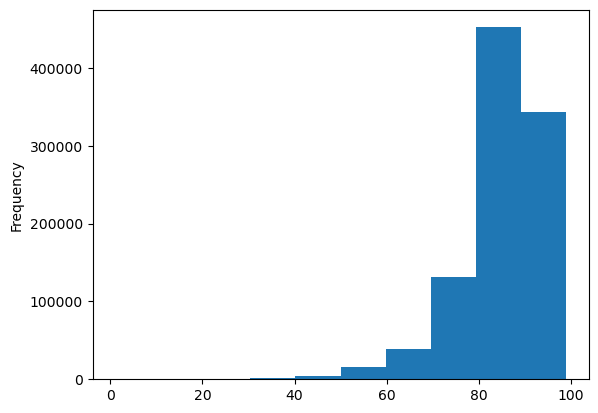

In [13]:
data['BirthYear'].plot(kind="hist")

Now that the birth years are almost corrected, the next step is to handle the records where the year of birth is less than 15.
 These years can represent two possibilities:
**Customers born in 1915 or earlier** — Their age would be very high, likely close to 100 or more, making them outliers.

**Customers born after 2000** — Their age would be around 15 or younger, which is unrealistic for the dataset, as it pertains to bank customers.
In both cases, these records can be treated as outliers and removed.

I will filter out the records where the birth year is less than 15, as they don't make sense in the context of this analysis.

Let's proceed to clean the data by removing these outliers.

<Axes: ylabel='Frequency'>

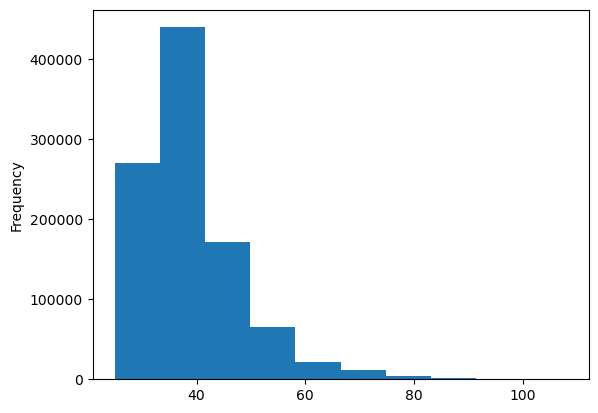

In [15]:
data = data[data['BirthYear']>15]
data['BirthYear'] = data['BirthYear']+1900
data['Age'] = 2024 - data['BirthYear']

# Lets plot the age
data['Age'].plot(kind="hist")

Customers aged over 90 might still be valid accounts in real-world data, especially if they are receiving pension-related transactions. 
However, for this analysis, these individuals can be considered outliers, as they might not represent the typical customer profile we're focusing on.
To address this:

- I will remove customers with an age greater than 90, treating them as outliers for the purpose of this segmentation analysis.

- These customers could still be valuable in the actual business context, but we'll exclude them for now to maintain the focus on more typical customer profiles.

Let me proceed with filtering out these outliers from the dataset.

In [17]:
#Calculating the Transaction frequency
data = data[data['Age']<90]
data.drop(columns=['CustomerDOB','TransactionTime','BirthYear'],inplace=True)

**Transaction Frequency**

Transaction frequency helps us understand how often customers use the bank’s services. To compute this, I will:

- Group the dataset by CustomerID.

Calculate the number of transactions each customer has made over a specific time period (e.g., within the past year).

This will give us insights into how active each customer is, which is crucial for the RFM analysis.

Let me now proceed to calculate the transaction frequency for each customer over the last year.

In [19]:
data['TransactionDate'] = pd.to_datetime(data['TransactionDate'])
transactions = data.groupby('CustomerID')['TransactionID'].nunique().reset_index()

trans_counts = transactions['TransactionID'].value_counts()
category_percentages = transactions['TransactionID'].value_counts(normalize=True) * 100

print(trans_counts)

C:\Users\sabar\AppData\Local\Temp\ipykernel_9128\215932022.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['TransactionDate'] = pd.to_datetime(data['TransactionDate'])


TransactionID
1    710735
2    113286
3     14347
4      1353
5       108
6         6
Name: count, dtype: int64


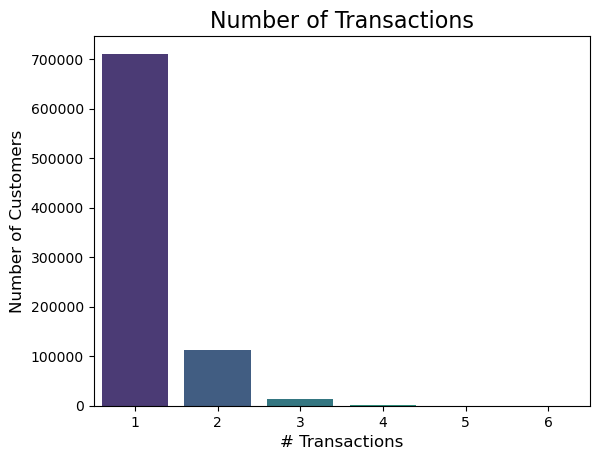

In [21]:
# Plotting a barplot using Seaborn

sns.barplot(x=trans_counts.index, y=trans_counts.values, palette='viridis')

plt.xlabel('# Transactions', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.title('Number of Transactions', fontsize=16)
plt.show()

**Transaction Frequency Insights:**

- Most customers (85%) have only made one transaction, which indicates that the majority of the customer base may not be highly active or might only engage with the bank occasionally.

- A small portion (0.17%, or 1,467 out of 839,835 customers) made more than four transactions, showing a more engaged and frequent group of customers.

**Recency of Last Transaction:**

To measure customer activity, Recency refers to the time elapsed since a customer’s most recent transaction. The formula is:

- Recency = CurrentDate - LastTransactionDate

This metric helps identify how recent and active each customer is in terms of their latest engagement with the bank.

I will now proceed to calculate the recency for each customer based on their last transaction date, providing us insights into customer activity levels.

In [23]:
#Measuring the recency of  last Transaction
data['TransactionDate'].min()

Timestamp('2016-01-08 00:00:00')

In [25]:
data['TransactionDate'].max()


Timestamp('2016-12-09 00:00:00')

In [27]:
## Lets create a recency to 2017 Jan 1st. Which will say how recent were the customer to the date Jan 1st of 2017

today_date = datetime(2017, 1, 1)

data['Recency'] = (today_date - data['TransactionDate']).dt.days
customer_recency = data.groupby('CustomerID')['Recency'].max().reset_index()

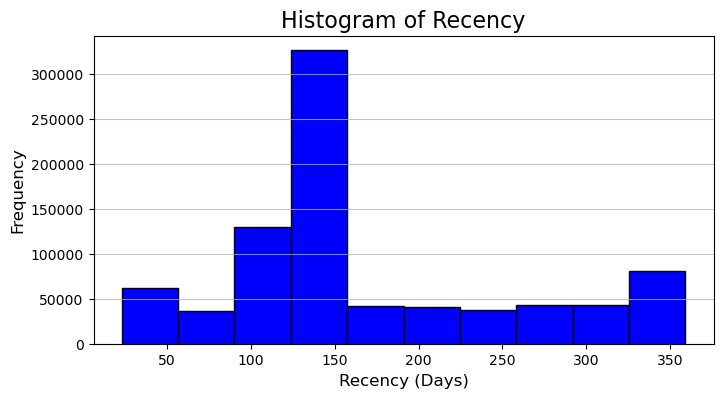

In [29]:
## Lets create a recency to 2017 Jan 1st. Which will say how recent were the customer to the date Jan 1st of 2017

today_date = datetime(2017, 1, 1)

data['Recency'] = (today_date - data['TransactionDate']).dt.days
customer_recency = data.groupby('CustomerID')['Recency'].max().reset_index()
# Plotting the histogram using Matplotlib
plt.figure(figsize=(8, 4))  # Set the figure size
plt.hist(customer_recency['Recency'], bins=10, color='blue', edgecolor='black')  # Histogram with 10 bins
plt.xlabel('Recency (Days)', fontsize=12)  # X-axis label
plt.ylabel('Frequency', fontsize=12)        # Y-axis label
plt.title('Histogram of Recency', fontsize=16)  # Title of the plot
plt.grid(axis='y', alpha=0.75)  # Optional: Add gridlines for better readability
plt.show()  # Display the plot

**Based on the recency analysis:**

- Inactive (Churned) Customers: Customers who haven't been active for more than 200-360 days. These customers are likely to have stopped engaging with the bank and can be categorized as "inactive" or "churned."

- High-Risk Customers: Customers who were last active between 120-200 days ago. While they aren't completely inactive, they are at a high risk of churning, so they represent a critical group for the bank to target with retention strategies, such as offering benefits to re-engage them.

Now, I will categorize the customers into these buckets and visualize the distribution of:

**1. Inactive/Churned customers**

**2.High-Risk customers**

**3.Active customers (recently engaged)**

Let’s visualize these buckets to get a clearer picture of how they are distributed across the customer base.

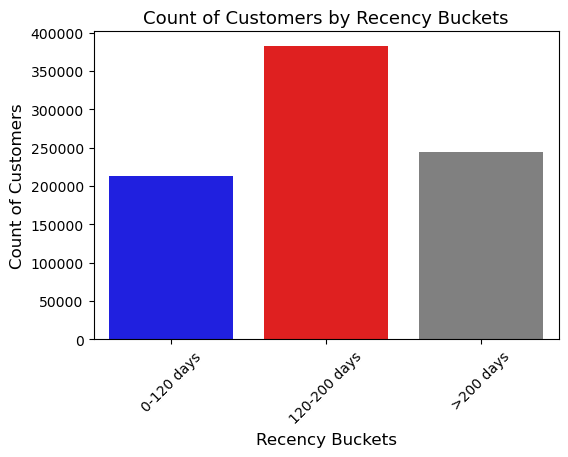

In [31]:
bins = [0, 120, 200, float('inf')]  # Define the bin edges
labels = ['0-120 days', '120-200 days', '>200 days']  # Define the labels for the bins

# Create a new column 'Recency_Bucket' based on the defined bins
customer_recency['Recency_Bucket'] = pd.cut(customer_recency['Recency'], bins=bins, labels=labels, right=False)

bucket_counts = customer_recency['Recency_Bucket'].value_counts()
colors = ['blue', 'red', 'grey']


plt.figure(figsize=(6, 4))  # Set the figure size
sns.barplot(x=bucket_counts.index, y=bucket_counts.values, palette=colors)
# Add labels and title
plt.xlabel('Recency Buckets', fontsize=12)
plt.ylabel('Count of Customers', fontsize=12)
plt.title('Count of Customers by Recency Buckets', fontsize=13)
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.show()  # Display the plo

In [35]:
#Average Transaction amount
data['Avg Transaction amnt'] = data.groupby('CustomerID')['TransactionAmount (INR)'].transform('sum')/data.groupby('CustomerID')['TransactionID'].transform('nunique')
avg_trans = data[['CustomerID','Avg Transaction amnt']].drop_duplicates()

avg_trans['Avg Transaction amnt'].describe()

count    839835.00
mean       1452.77
std        6041.69
min           0.00
25%         180.00
50%         474.50
75%        1175.00
max     1560034.99
Name: Avg Transaction amnt, dtype: float64

<Axes: >

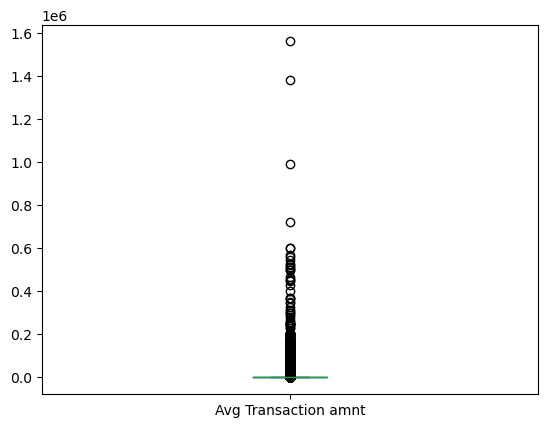

In [37]:
avg_trans['Avg Transaction amnt'].plot(kind='box')

The presence of a long tail in transaction amounts is typical in many real-world datasets, where a small number of customers make very high-value transactions. These high transactions are not necessarily outliers, but they can heavily skew the distribution.

To better visualize and understand this distribution, we can apply a transformation, such as a logarithmic transformation, which will help compress the long tail and make it easier to analyze the majority of the data.

Let me apply a logarithmic transformation to the transaction amounts and then plot the transformed data to see how the distribution looks. This will help us gain better insights into the distribution of transaction amounts while minimizing the effect of extreme values.

<Axes: >

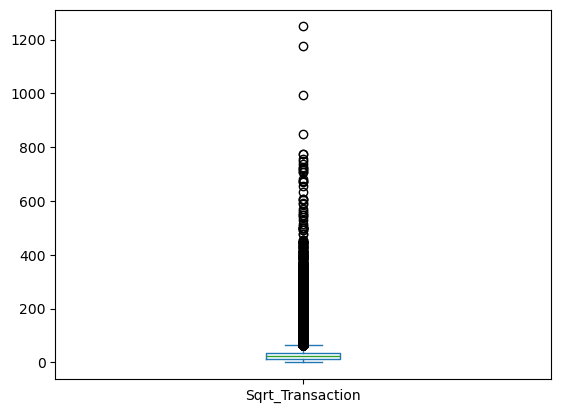

In [39]:
avg_trans['Sqrt_Transaction'] =  np.sqrt(avg_trans['Avg Transaction amnt'])
avg_trans['Sqrt_Transaction'].plot(kind='box')

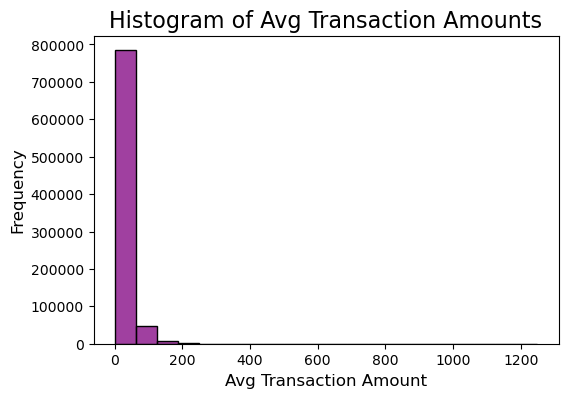

In [41]:
#Histogram of Average transaction Amounts
plt.figure(figsize=(6, 4))
sns.histplot(avg_trans['Sqrt_Transaction'], bins=20,  color="purple")
plt.title('Histogram of Avg Transaction Amounts', fontsize=16)
plt.xlabel('Avg Transaction Amount', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

The right-skewed distribution of transaction amounts, with some very high transactions and low frequency, suggests that a small subset of customers is responsible for the majority of high-value transactions. This pattern is common, where most customers engage with the bank at a low level, while a few make infrequent but large transactions.

Now, focusing on the **spending behavior of active customers** (those who have made recent transactions) will help provide more meaningful insights. These customers are likely to be more engaged, and understanding their spending patterns can offer valuable information for targeted marketing or service improvement.

Let me filter out the active customers based on the Recency metric and analyze their transaction behavior. I'll plot the transaction distribution and summarize the key characteristics of their spending patterns.

In [43]:
avg_trans = avg_trans.merge(customer_recency,on='CustomerID',how='left')

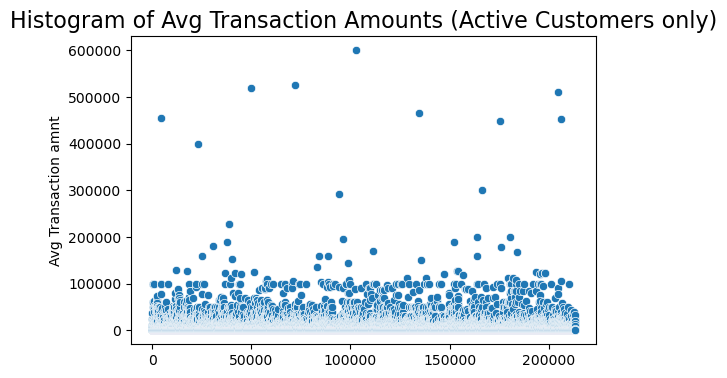

In [47]:
#Histogram of Average Transaction Amount for only Active Customers
data_temp = avg_trans[avg_trans['Recency_Bucket']=='0-120 days'].reset_index()['Avg Transaction amnt']
plt.figure(figsize=(6, 4))
sns.scatterplot(data_temp)
plt.title('Histogram of Avg Transaction Amounts (Active Customers only)', fontsize=16)

plt.show()

**Transaction Variability**

To assess how consistent or erratic a customer’s spending is, we can calculate the standard deviation of transaction amounts for each customer. A high standard deviation indicates that the customer’s spending is highly variable, which could suggest:

- **Sporadic big purchases:** Occasional large transactions interspersed with smaller or more frequent purchases.

- **Unstable spending behavior:** Inconsistent spending patterns, which may require further attention from the bank for customer retention or targeted offers.

In [49]:
## Lets look at only active customers

Active_customers = customer_recency[customer_recency['Recency_Bucket']=='0-120 days']['CustomerID']
freeq_customers = transactions[transactions['TransactionID']>1]['CustomerID']
Active_customers = list(set(Active_customers) & set(freeq_customers))


## Calculating the std of transaction amount by customer

trasn_std = data.groupby('CustomerID')['TransactionAmount (INR)'].std().reset_index()
active_cust_trans_std = trasn_std[trasn_std['CustomerID'].isin(Active_customers)]
active_cust_trans_std['TransactionAmount (INR)'].describe

<bound method NDFrame.describe of 0        3107.03
63       2375.88
66        251.02
100        36.06
316       180.31
           ...  
837864    424.26
837948     89.80
838053   5067.83
838547    213.09
839009    261.63
Name: TransactionAmount (INR), Length: 9590, dtype: float64>

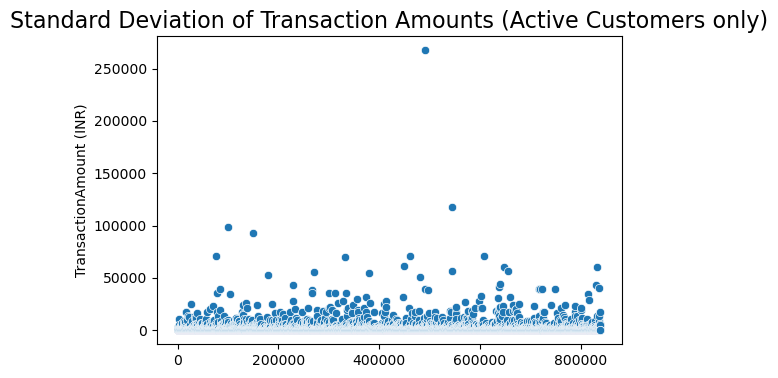

In [51]:
#Standard Deviation of Transaction amount for only active customers
plt.figure(figsize=(6, 4))
sns.scatterplot(active_cust_trans_std['TransactionAmount (INR)'])
plt.title('Standard Deviation of Transaction Amounts (Active Customers only)', fontsize=16)

plt.show()

**Balance Change**

By calculating the **change in balance after each transaction,** we can track whether a customer is saving, withdrawing, or topping up funds. 
This can be done by looking at the CustAccountBalance over time and calculating the difference in the balance after each transaction.

Changes in balance can give us valuable insights into a customer's behavior:

- **Positive balance change:** Indicates the customer is depositing or topping up funds.

- **Negative balance change:** Indicates the customer is withdrawing or spending money.

- **Zero or little change:** May suggest the customer is maintaining a steady balance, either through regular savings or passive account activity.

Let me now calculate the balance changes over time for each customer and analyze how the balance trends across different customers. 
This can help understand their saving or spending behavior more clearly.

In [53]:
Active_customers = customer_recency[customer_recency['Recency_Bucket']=='0-120 days']['CustomerID']
freeq_customers = transactions[transactions['TransactionID']>2]['CustomerID']
Active_customers = list(set(Active_customers) & set(freeq_customers))

## As we have max of 6 trasnactions in the data, we will create 6 lag values of account balance feature. 
## These lag values gives us the time series view of account balance after each trasactions.
## With that done we will try to get an idea of whether amounts are withdrawn or saved over time


## Sorting and filtering the data for active customers.

balance_change_temp = data.sort_values(by=['CustomerID', 'TransactionDate'])
balance_change_temp = balance_change_temp[balance_change_temp['CustomerID'].isin(Active_customers)]


## Creating lag values columns

balance_change_temp['lag1_balance'] = balance_change_temp.groupby('CustomerID')['CustAccountBalance'].shift(1)
balance_change_temp['lag2_balance'] = balance_change_temp.groupby('CustomerID')['CustAccountBalance'].shift(2)
balance_change_temp['lag3_balance'] = balance_change_temp.groupby('CustomerID')['CustAccountBalance'].shift(3)
balance_change_temp['lag4_balance'] = balance_change_temp.groupby('CustomerID')['CustAccountBalance'].shift(4)
balance_change_temp['lag5_balance'] = balance_change_temp.groupby('CustomerID')['CustAccountBalance'].shift(5)
balance_change_temp['lag6_balance'] = balance_change_temp.groupby('CustomerID')['CustAccountBalance'].shift(6)

In [55]:
balance_change_temp.head()

,TransactionID,CustomerID,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionAmount (INR),Age,Recency,Avg Transaction amnt,lag1_balance,lag2_balance,lag3_balance,lag4_balance,lag5_balance,lag6_balance
202396,T202397,C1017576,M,GURGAON,4629.37,2016-09-08,2165.00,33.00,115,1754.00,NaN,NaN,NaN,NaN,NaN,NaN
268369,T268370,C1017576,M,HATHRAS,9129.33,2016-12-08,100.00,32.00,24,1754.00,4629.37,NaN,NaN,NaN,NaN,NaN
913326,T913327,C1017576,M,BAMBOLIM,246292.37,2016-12-09,2997.00,47.00,23,1754.00,9129.33,4629.37,NaN,NaN,NaN,NaN
312810,T312811,C1018516,F,DIMAPUR,3838.67,2016-10-08,290.00,31.00,85,1345.33,NaN,NaN,NaN,NaN,NaN,NaN
926726,T926727,C1018516,M,AHMEDABAD,175.13,2016-11-09,630.00,30.00,53,1345.33,3838.67,NaN,NaN,NaN,NaN,NaN


To clean the dataset and retain only the most recent transaction for each customer, we will:

**1.Remove unwanted initial rows** that contain outdated or duplicate information, focusing on the most recent record for each customer.

**2.Keep only the last transaction** row for each customer, as it will represent the most up-to-date transaction data, including the total activity over time.

This will streamline the dataset, ensuring that we are working with the most relevant and current data for each customer.


Let's go ahead and filter the data to retain only the last transaction for each customer.

In [57]:
transaction_data = balance_change_temp.drop_duplicates(subset='CustomerID',keep='last')

To analyze the **balance trends** of customers and correlate them with the type of account they belong to, we will:

**1.Plot the balance change trend** over time for the most recent transactions.

**2.Categorize customers by account type** (e.g., savings, checking, business) to examine whether different account types show different balance trends.

This will help us identify any patterns based on the type of account, allowing us to tailor services or insights based on customer needs.

Let me proceed by visualizing the balance trends and segmenting the data based on account type.

To analyze the balance trends of customers and correlate them with the type of account they belong to, we will:

Plot the balance change trend over time for the most recent transactions.

Categorize customers by account type (e.g., savings, checking, business) to examine whether different account types show different balance trends.

This will help us identify any patterns based on the type of account, allowing us to tailor services or insights based on customer needs.

Let me proceed by visualizing the balance trends and segmenting the data based on account type.

In [59]:
# Define a function to check the trend
def check_trend(row):
    lags = [row['lag6_balance'], row['lag5_balance'], row['lag4_balance'], 
            row['lag3_balance'], row['lag2_balance'], row['lag1_balance'],row['CustAccountBalance']]
    
    # Remove any NaN values if there are missing lags
    lags = [x for x in lags if pd.notnull(x)]
    
    # Check if all lag values are increasing
    if all(x < y for x, y in zip(lags, lags[1:])):
        return 'saving'
    
    # Check if all lag values are decreasing
    elif all(x > y for x, y in zip(lags, lags[1:])):
        return 'withdrawing'
    
    # If neither increasing nor decreasing, the trend is mixed
    else:
        return 'mixed'

In [61]:
# Apply the function to each row of the DataFrame
transaction_data['trend'] = transaction_data.apply(check_trend, axis=1)

C:\Users\sabar\AppData\Local\Temp\ipykernel_9128\1839877204.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transaction_data['trend'] = transaction_data.apply(check_trend, axis=1)


. The analysis of the balance trends reveals some important insights:

**1.Salary Accounts (Both Depositing and Withdrawing):**
A significant number of accounts show both deposit and withdrawal activity, indicating that these customers likely use the account for regular income (e.g., salary) deposits and subsequent withdrawals. This behavior is typical of salary accounts, where customers frequently deposit their earnings and withdraw funds for day-to-day expenses.

**2.Savings and Withdrawal-Only Accounts:**
Fewer accounts show patterns that are primarily limited to withdrawals or deposits only, with balances either being consistently saved or withdrawn. These accounts could represent customers who are more focused on savings or have minimal transactional activity, likely indicating personal savings accounts or investment accounts with infrequent withdrawals.

In [63]:
transaction_data = transaction_data[['CustomerID','trend']]
transaction_data = transaction_data['trend'].value_counts().reset_index()

In [65]:
transaction_data

,trend,count
0,mixed,239
1,withdrawing,58
2,saving,51


<Axes: xlabel='trend', ylabel='count'>

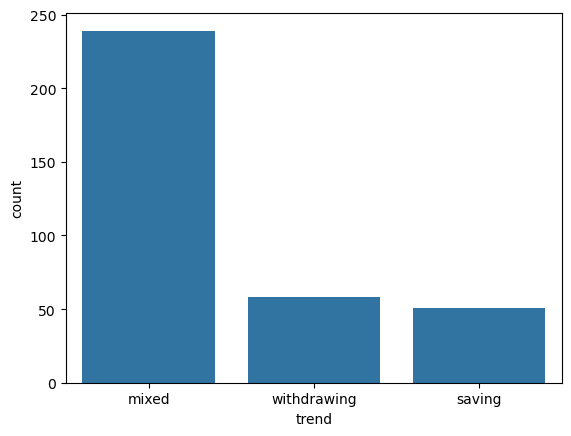

In [67]:
#Bar plot
sns.barplot(x=transaction_data['trend'],y=transaction_data['count'])

**RFM Analysis (Recency, Frequency, Monetary Value)**

RFM analysis is a powerful tool for customer segmentation, helping us categorize customers based on their transaction behavior:

**Recency (R):** How recent was their last transaction? More recent transactions indicate more active customers.

**Frequency (F):** How often do they transact? Frequent customers are typically more engaged.

**Monetary (M):** How much do they spend? Higher spenders are valuable to the business.

**Steps for RFM Analysis:**

**1.Score Assignment for Recency, Frequency, and Monetary:**
- We'll assign scores to each feature (R, F, M) based on their values, such that higher values (more recent, more frequent, higher spending) get higher scores.
- These scores typically range from 1 to 5, where 1 is the lowest value (least favorable) and 5 is the highest (most favorable).

**2.Segmenting the Customers:**
- Once we have scores for each feature, we'll combine the scores for R, F, and M to create different segments of customers.
- For example, a customer with high scores in all three features would be in a top segment, while a customer with low scores in all three might be considered "at-risk."

In [69]:
#RFM analysis (Recency,Frequency,Monetary)
## Creating a dataframe to keep all customers info:

RFM_data = pd.DataFrame()
all_customers = data['CustomerID'].unique()

RFM_data['CustomerID'] = all_customers


## Merging with Transactions data to get # unique transactions made
RFM_data = RFM_data.merge(transactions,on='CustomerID',how='left')
RFM_data.rename(columns={'TransactionID':'Frequency'},inplace=True)


## Merging with Recency data to get recency of each customer
RFM_data = RFM_data.merge(customer_recency[['CustomerID','Recency']],on='CustomerID',how='left')


## Merging with Avg transactio data to get monetary value of customers
RFM_data = RFM_data.merge(avg_trans[['CustomerID','Avg Transaction amnt']],on='CustomerID',how='left')

In [71]:
RFM_data.head()

,CustomerID,Frequency,Recency,Avg Transaction amnt
0,C5841053,1,328,25.00
1,C2142763,1,328,27999.00
2,C4417068,1,328,459.00
3,C5342380,2,328,1469.20
4,C9031234,1,328,1762.50


In [73]:
# Assign R, F, and M scores by dividing into quintiles
RFM_data['R_Score'] = pd.qcut(RFM_data['Recency'], 5, labels=[5, 4, 3, 2, 1], duplicates='drop')

RFM_data['F_Score'] = pd.cut(RFM_data['Frequency'], bins=5, labels=[1, 2, 3, 4, 5])


## Since Avg Transaction is highly skewed, will transform the value first and then cut them into bins
RFM_data['LogMonetaryValue'] = np.log1p(RFM_data['Avg Transaction amnt'])
RFM_data['M_Score'] = pd.qcut(RFM_data['LogMonetaryValue'], 5, labels=[1, 2, 3, 4, 5], duplicates='drop')

In [75]:
# Combine R, F, and M scores into a single RFM Score
RFM_data['RFM_Score'] = RFM_data['R_Score'].astype(str) + RFM_data['F_Score'].astype(str) + RFM_data['M_Score'].astype(str)

**Customer Segments Based on RFM Scores:**

**1.Best Customers:**
- **Criteria:** High scores in all three RFM features (Recency, Frequency, and Monetary).
- **Characteristics:** These are the most valuable customers who are recent, frequent, and spend a lot. They should be prioritized for loyalty programs and high-value offerings.

**2.Loyal Customers:**
- **Criteria:** High Frequency and Monetary scores, but possibly lower Recency.
-**Characteristics:** These customers transact frequently and spend well, but may not have transacted recently. Retargeting with personalized offers can help bring them back.

**3.At-Risk Customers:**
- **Criteria:** High Frequency and Monetary scores in the past, but low Recency.
-**Characteristics:** These customers were once high-value but haven’t transacted recently. These customers are at risk of churning, so engagement through incentives is crucial to retain them.

**4.New Customers:**
- **Criteria:** High Recency, but low Frequency and Monetary scores.
- **Characteristics:** These customers have recently made their first transaction, but haven’t been frequent or spent much yet. Targeting them with personalized offers can help turn them into loyal customers
Hibernating Customers:

**5.Hibernating Customers:**
- **Criteria:** Low Recency, Frequency, and Monetary scores.
- **Characteristics:** These customers haven’t been active for a while and have low transaction activity. Re-engagement strategies are necessary to bring them back into the fold.

**6.Big Spenders:**
- **Criteria:** High Monetary score but low Recency and Frequency.
- **Characteristics:** These customers tend to make large transactions but are not frequent or recent. They should be targeted with personalized, high-value offers to encourage more frequent transactions.

**7.Other:**
**Criteria:** Customers who do not fit neatly into the above categories.
**Characteristics:** This category acts as a catch-all for customers whose behavior doesn't align with the predefined segments. They can still be further analyzed or targeted with generic marketing efforts.



In [77]:
#We can now segment customers based on these RFM scores
#Here we are going to use segments like Best customers,Loyal Customers,At-risk Customers,New Customers,Hibernating Customers,Big spenders and others
def rfm_segment(df):
    if df['R_Score'] in ['4', '5'] and df['F_Score'] in ['4', '5'] and df['M_Score'] in ['4', '5']:
        return 'Best Customers'
    elif df['R_Score'] in ['3','4', '5'] and df['F_Score'] in ['4', '5'] and df['M_Score'] in ['3','4', '5']:
        return 'Loyal Customers'
    elif df['R_Score'] in ['1','2'] and df['F_Score'] in ['4', '5'] and df['M_Score'] in ['3','4', '5']:
        return 'At-Risk Customers'
    elif df['R_Score'] in ['4','5'] and df['F_Score'] in ['1','2'] and df['M_Score'] in ['1','2']:
        return 'New Customers'
    elif df['R_Score'] in ['1','2'] and df['F_Score'] in ['1','2'] and df['M_Score'] in ['1','2','3']:
        return 'Hibernating Customers'
    elif df['M_Score'] in ['4', '5'] and df['R_Score'] in ['1', '2'] and df['F_Score'] in ['1', '2']:
        return 'Big Spenders'
    else:
        return 'Other'



In [79]:
# Apply the segment labeling function to each row
# RFM_data['RFM_Score'] = RFM_data['RFM_Score'].astype(str)
RFM_data['R_Score'] = RFM_data['R_Score'].astype(str)
RFM_data['F_Score'] = RFM_data['F_Score'].astype(str)
RFM_data['M_Score'] = RFM_data['M_Score'].astype(str)

RFM_data['Segment'] = RFM_data.apply(rfm_segment, axis=1)

In [81]:
RFM_data.head()

,CustomerID,Frequency,Recency,Avg Transaction amnt,R_Score,F_Score,LogMonetaryValue,M_Score,RFM_Score,Segment
0,C5841053,1,328,25.00,1,1,3.26,1,111,Hibernating Customers
1,C2142763,1,328,27999.00,1,1,10.24,5,115,Big Spenders
2,C4417068,1,328,459.00,1,1,6.13,3,113,Hibernating Customers
3,C5342380,2,328,1469.20,1,1,7.29,4,114,Big Spenders
4,C9031234,1,328,1762.50,1,1,7.48,5,115,Big Spenders


In [84]:
print(RFM_data[['CustomerID', 'RFM_Score', 'Segment']])

       CustomerID RFM_Score                Segment
0        C5841053       111  Hibernating Customers
1        C2142763       115           Big Spenders
2        C4417068       113  Hibernating Customers
3        C5342380       114           Big Spenders
4        C9031234       115           Big Spenders
...           ...       ...                    ...
839830   C5028150       515                  Other
839831   C1034220       514                  Other
839832   C8020229       514                  Other
839833   C6459278       513                  Other
839834   C6420483       514                  Other

[839835 rows x 3 columns]


In [86]:
segments_count = RFM_data['Segment'].value_counts().reset_index()
segments_count

,Segment,count
0,Other,372641
1,Hibernating Customers,186871
2,New Customers,146598
3,Big Spenders,133622
4,At-Risk Customers,90
5,Loyal Customers,12
6,Best Customers,1


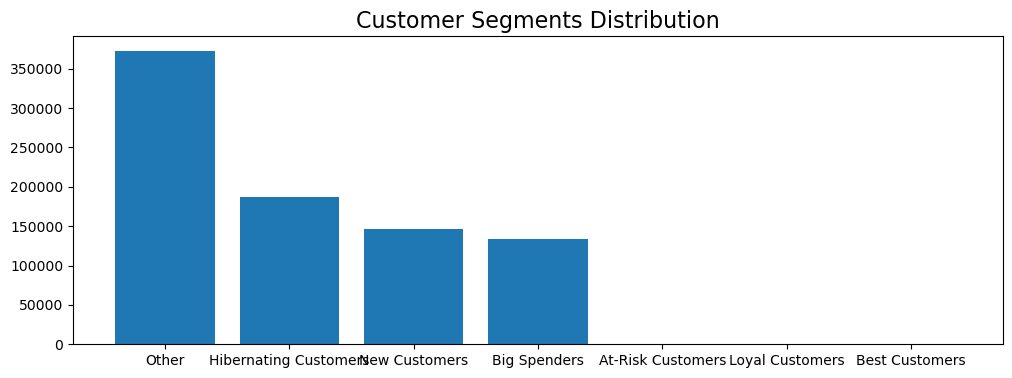

In [88]:
plt.figure(figsize=(12, 4))
plt.bar(segments_count['Segment'],segments_count['count'])
# plt.legend(segments_count['Segment'], title="Segments", loc="best")
plt.title('Customer Segments Distribution', fontsize=16)
# plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

**Next Steps:**
- Now that we have these customer segments, we can assign each customer to one of the segments based on their RFM scores.

- We can then perform additional analysis to understand the size of each segment and explore further actions like targeted marketing strategies.

- Let me know if you'd like to dive deeper into these segments or visualize the distribution!

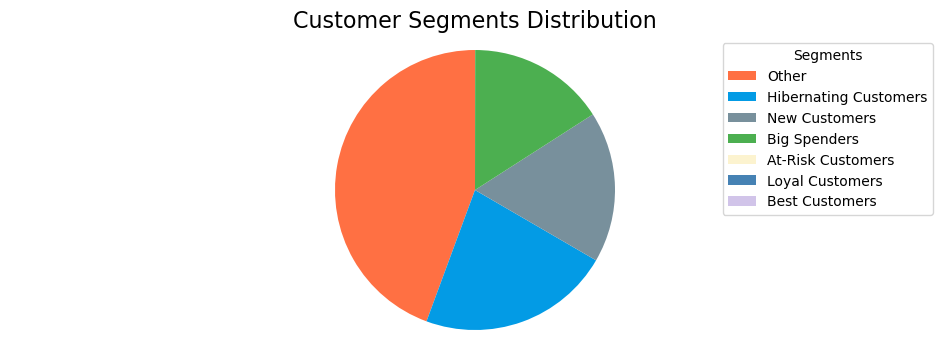

In [90]:
# Define custom colors for each segment
colors = ['#ff7043',  # Other 
          '#039be5',  # Big spenders
          '#78909c',  # Hibernating
          '#4caf50',  # New
          '#fcf3cf',  # At Risk
          '#4682B4',  # 
          '#d1c4e9']  # 


plt.figure(figsize=(12, 4))
plt.pie(segments_count['count'], startangle=90, colors=colors)
plt.legend(segments_count['Segment'], title="Segments", loc="best")
plt.title('Customer Segments Distribution', fontsize=16)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

**Customer Profiling & Segmentation:**

**1.Best Customers:** High Recency, Frequency, and Monetary scores.
 - **Profile:** Most engaged, frequent transactions, and high spenders.
 - **Action:** Retain with personalized offers and loyalty programs.

**2.Loyal Customers:** High Frequency and Monetary scores, lower Recency.
- **Profile:** Frequent spenders but less recent activity.
- **Action:** Engage with incentives to encourage more frequent transactions.

**3.At-Risk Customers:** High Frequency and Monetary, low Recency.
- **Profile:** Previously valuable, but inactive recently.
- **Action:** Target with re-engagement campaigns.

**4.New Customers:** High Recency, low Frequency and Monetary.
- **Profile:** Recent customers with low transaction activity.
- **Action:** Engage with welcome offers to increase activity.

**5.Hibernating Customers:** Low Recency, Frequency, and Monetary scores.
- **Profile:** Minimal interaction, close to churn.
- **Action:** Try reactivation strategies.

**6.Big Spenders:** High Monetary, low Recency and Frequency.
- **Profile:** High-value but infrequent spenders.
- **Action:** Encourage more frequent transactions with tailored offers.

**7.Lost Customers:** Low Recency, Frequency, and Monetary.
- **Profile:** Long-term inactivity.
- **Action:** Re-engage with special campaigns, though chances are low.

**8.Other Segments:** Mid-range RFM scores.
- **Profile:** Moderate engagement.
- **Action:** Monitor and target for increased activity.

**Conclusion:**
In this project, we performed an **Exploratory Data Analysis (EDA)** and followed it with **RFM segmentation** to categorize the bank’s customer base into meaningful segments. By analyzing Recency, Frequency, and Monetary behavior, we identified actionable insights for each customer group, allowing the bank to adopt personalized marketing strategies for better customer engagement.

**Key Takeaways:**
- **High-value customers** (Best Customers) should be retained with premium offers and loyalty programs.
- **At-risk customers** need re-engagement strategies to prevent churn.
- **New customers** offer growth potential but need nurturing to become loyal and high-frequency users.

**Next Steps:**
- Monitor customer movement across segments over time to understand changing behaviors and adjust strategies accordingly.
- Integrate additional data (e.g., demographics, customer preferences) to further refine segmentation and create even more targeted strategies.
- Track the effectiveness of engagement campaigns to measure success and fine-tune future marketing efforts.

This detailed segmentation empowers the bank to offer tailored services, improve customer satisfaction, and increase profitability.